In [1]:
# !pip install pandas_datareader
# !pip install pmdarima

In [2]:
import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')
import itertools
import warnings
warnings.filterwarnings('ignore')

In [3]:
import yfinance as yf
df = yf.download('005930.KS',
                     start='2022-01-01',
                     end='2022-05-12') # 005930 : 삼성전자 주가

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,78800.0,79200.0,78300.0,78700.0,78295.289062,12427416
2022-01-05,78800.0,79000.0,76400.0,77400.0,77001.976562,25470640
2022-01-06,76700.0,77600.0,76600.0,76900.0,76504.546875,12931954
2022-01-07,78100.0,78400.0,77400.0,78300.0,77897.343750,15163757
2022-01-10,78100.0,78100.0,77100.0,78000.0,77598.890625,9947422


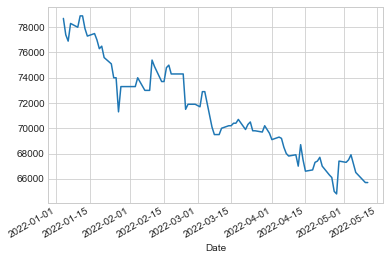

In [4]:
# data check
fig = df['Close'].plot()

## 1. Decomposition

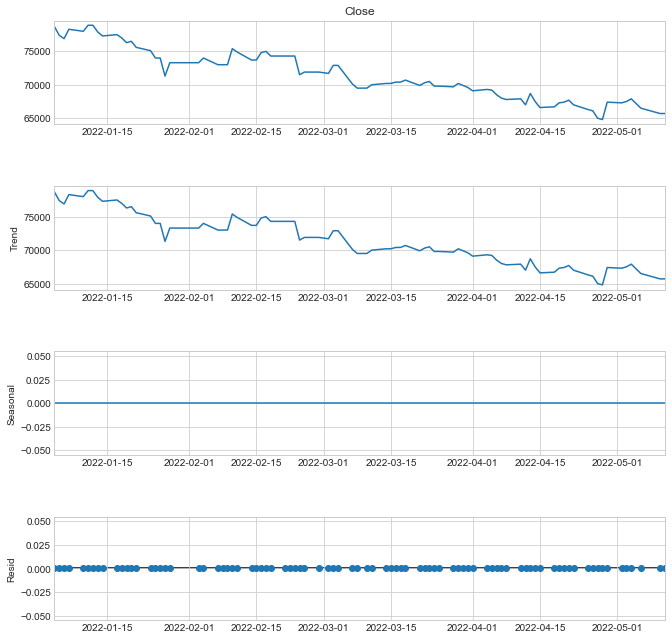

In [5]:
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

In [6]:
# split 8 : 2
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

## 2. ACF, PACF

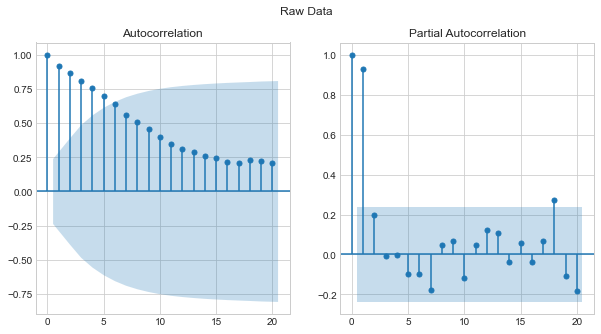

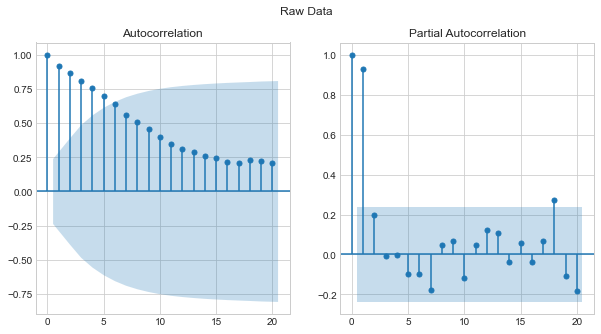

In [29]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data['Close'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['Close'].values.squeeze(), lags=20, ax=ax[1])

In [8]:
star = '*'

## 3. Differencing

In [36]:
# Non-stationary -> stationary 보정 (차분, difference)
# differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Close'].diff() # 차분
diff_train_data = diff_train_data.dropna() # 차분 후 생기는 결측치 제거
print(f'{star*15}Raw data{star*15}')
print(train_data['Close'].head())
print(f'{star*15}Differenced data{star*15}')
print(diff_train_data.head())

***************Raw data***************
Date
2022-01-04    78700.0
2022-01-05    77400.0
2022-01-06    76900.0
2022-01-07    78300.0
2022-01-10    78000.0
Name: Close, dtype: float64
***************Differenced data***************
Date
2022-01-05   -1300.0
2022-01-06    -500.0
2022-01-07    1400.0
2022-01-10    -300.0
2022-01-11     900.0
Name: Close, dtype: float64


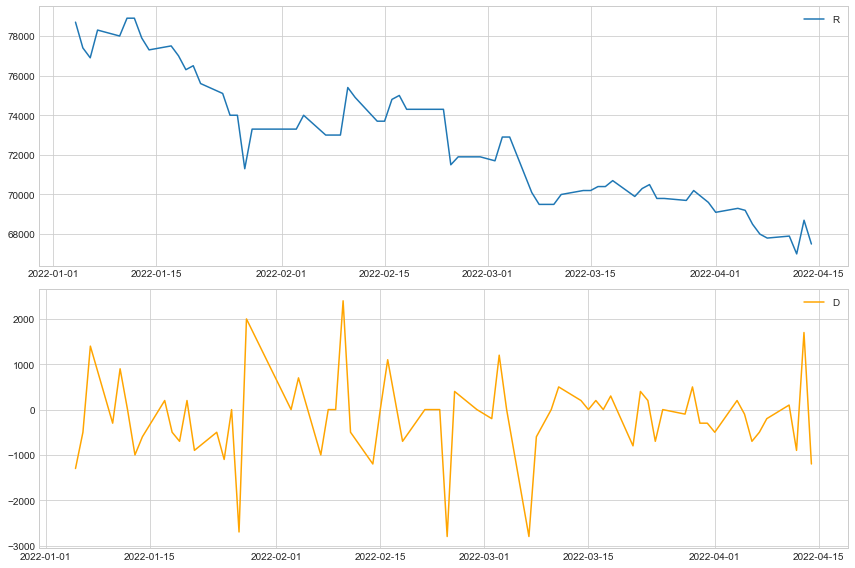

In [10]:
# 차분 시각화

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(train_data['Close'])
ax1.legend('Raw data (Non-stationary)')

ax2.plot(diff_train_data, color='orange' )
ax2.legend('Differenced data (stationary)')


plt.tight_layout()
plt.show()

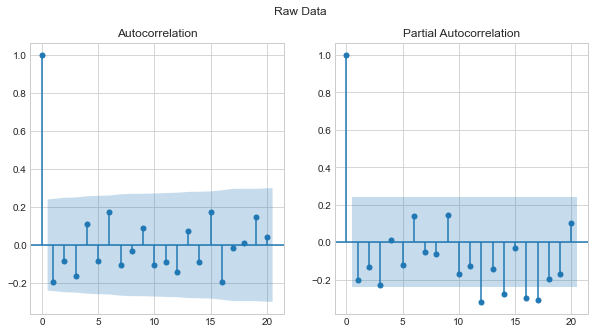

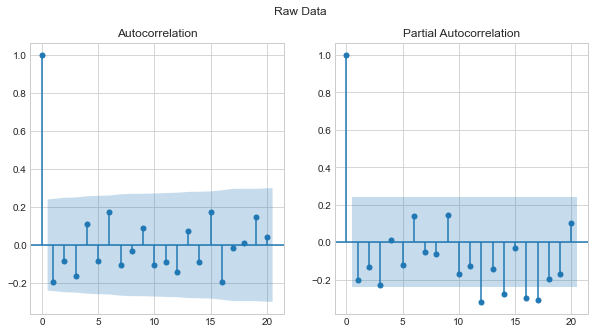

In [30]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=20, ax=ax[1])

In [12]:
model = ARIMA(train_data['Close'].values, order=(1, 2, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   68
Model:                     ARMA(0, 0)   Log Likelihood                -646.340
Method:                           css   S.D. of innovations           3248.867
Date:                Fri, 13 May 2022   AIC                           1296.680
Time:                        10:29:22   BIC                           1301.119
Sample:                             0   HQIC                          1298.439
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.265e+04    393.983    184.406      0.000    7.19e+04    7.34e+04
==============================================================================
"""

## 4. Diagnosis 

In [13]:
# 최적 파라미터 서치

p = range(0, 2)
d = range(1, 3)
q = range(0, 2)
pdq = list(itertools.product(p, d, q))

AIC = []
for i in pdq :
    model = ARIMA(train_data['Close'].values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA pdq : {i} >> AIC : {round(model_fit.aic, 2)}')
    AIC.append(round(model_fit.aic, 2))

ARIMA pdq : (0, 1, 0) >> AIC : 1107.1
ARIMA pdq : (0, 1, 1) >> AIC : 1105.21
ARIMA pdq : (0, 2, 0) >> AIC : 1148.01
ARIMA pdq : (0, 2, 1) >> AIC : 1097.79
ARIMA pdq : (1, 1, 0) >> AIC : 1106.39
ARIMA pdq : (1, 1, 1) >> AIC : 1101.45
ARIMA pdq : (1, 2, 0) >> AIC : 1127.02
ARIMA pdq : (1, 2, 1) >> AIC : 1097.45


In [14]:
# optimal paramter
optim = [(pdq[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print('Found Optimal Parameter :',optim)

Found Optimal Parameter : [((1, 2, 1), 1097.45)]


In [15]:
model = ARIMA(train_data['Close'].values, order=(1, 2, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   66
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -544.727
Method:                       css-mle   S.D. of innovations            897.634
Date:                Fri, 13 May 2022   AIC                           1097.453
Time:                        10:29:22   BIC                           1106.212
Sample:                             2   HQIC                          1100.914
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2089      4.799      0.252      0.801      -8.196      10.614
ar.L1.D2.y    -0.1902      0.123     -1.547      0.122      -0.431       0.051
ma.L1.D2.y    -1.0000      0.040    -24.818      0.000      -1.079      -0.921
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.2579           +0.0000j            5.2579            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

## 5. Forecasting with ARIMA

In [16]:
pred = model_fit.forecast(len(test_data))
pred_val = pred[0]
pred_ub = pred[2][:, 0]
pred_lb = pred[2][:, 1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)

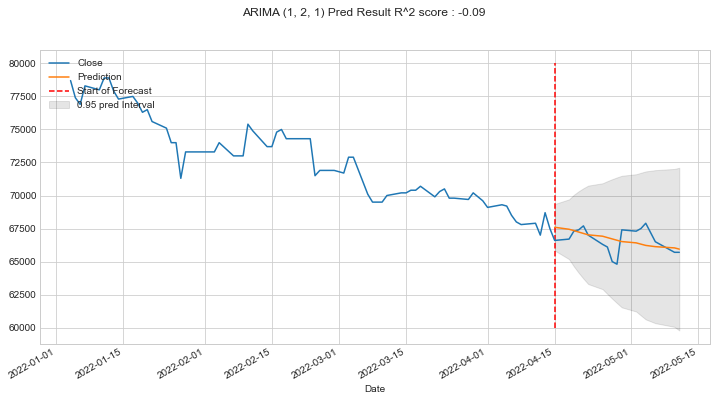

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.vlines('2022-04-15', 60000, 80000, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()

## 6. Diagnosis - SARIMA

In [18]:
train_data.shape

(68, 6)

In [19]:
# parameter search

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in pdq]

AIC = []
params = []
for i in pdq :
    for j in seasonal_pdq :
        try : 
            model = SARIMAX(train_data['Close'].values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA : {i},{j} >> AIC : {round(model_fit.aic, 2)}')
            AIC.append(round(model_fit.aic, 2))
            params.append((i, j))
            
        except Exception as e:
            print(e)
            continue

SARIMA : (0, 1, 0),(0, 1, 0, 3) >> AIC : 1108.05
SARIMA : (0, 1, 0),(0, 1, 1, 3) >> AIC : 1113.08
SARIMA : (0, 1, 0),(0, 1, 2, 3) >> AIC : 1119.88
SARIMA : (0, 1, 0),(1, 1, 0, 3) >> AIC : 1109.95
SARIMA : (0, 1, 0),(1, 1, 1, 3) >> AIC : 1112.04
SARIMA : (0, 1, 0),(1, 1, 2, 3) >> AIC : 1113.95
SARIMA : (0, 1, 0),(2, 1, 0, 3) >> AIC : 1111.56
SARIMA : (0, 1, 0),(2, 1, 1, 3) >> AIC : 1110.21
SARIMA : (0, 1, 0),(2, 1, 2, 3) >> AIC : 1112.53
SARIMA : (0, 1, 1),(0, 1, 0, 3) >> AIC : 1108.84
SARIMA : (0, 1, 1),(0, 1, 1, 3) >> AIC : 1110.75
SARIMA : (0, 1, 1),(0, 1, 2, 3) >> AIC : 1112.39
SARIMA : (0, 1, 1),(1, 1, 0, 3) >> AIC : 1110.76
SARIMA : (0, 1, 1),(1, 1, 1, 3) >> AIC : 1112.22
SARIMA : (0, 1, 1),(1, 1, 2, 3) >> AIC : 1114.15
SARIMA : (0, 1, 1),(2, 1, 0, 3) >> AIC : 1112.39
SARIMA : (0, 1, 1),(2, 1, 1, 3) >> AIC : 1110.4
SARIMA : (0, 1, 1),(2, 1, 2, 3) >> AIC : 1112.37
SARIMA : (0, 1, 2),(0, 1, 0, 3) >> AIC : 1110.12
SARIMA : (0, 1, 2),(0, 1, 1, 3) >> AIC : 1112.08
SARIMA : (0, 1, 2),(0

In [20]:
# optimal parameter
optim = [(params[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print(optim)

[(((2, 1, 2), (0, 1, 0, 3)), 1106.87)]


## 7. Forecasting with SARIMA

In [21]:
model = SARIMAX(train_data['Close'].values, order=optim[0][0][0], seasonal_order=optim[0][0][1])
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   68
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 3)   Log Likelihood                -548.434
Date:                            Fri, 13 May 2022   AIC                           1106.868
Time:                                    10:29:34   BIC                           1117.663
Sample:                                         0   HQIC                          1111.121
                                             - 68                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1333      0.068     16.645      0.000       1.000       1.267
ar.L2         -0.9645      0.056    -17.141      0.000      -1.075      -0.854
ma.L1         -1.1538      0.065    -17.619      0.000      -1.282      -1.025
ma.L2          0.9782      0.062     15.682      0.000       0.856       1.100
sigma2      1.878e+06   5.69e-09    3.3e+14      0.000    1.88e+06    1.88e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.87   Jarque-Bera (JB):                 6.60
Prob(Q):                              0.03   Prob(JB):                         0.04
Heteroskedasticity (H):               0.26   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.92e+30. Standard errors may be unstable.
"""

In [22]:
pred = model_fit.get_forecast(len(test_data))
pred_val = pred.predicted_mean
pred_ub = pred.conf_int()[:, 0]
pred_lb = pred.conf_int()[:, 1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)

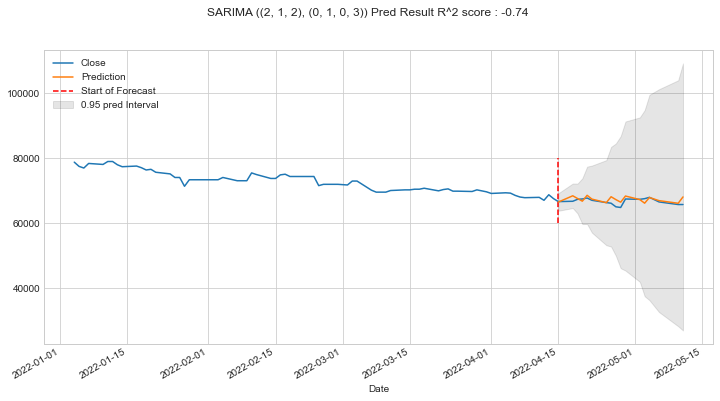

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.vlines('2022-04-15', 60000, 80000, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')

ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()

## 8. auto ARIMA

In [24]:
# 파라미터 탐색

auto_arima_model = auto_arima(train_data['Close'], start_p=1, start_q=1, 
                             max_p=3, max_1=3, m=3, seasonal=True, # sarima(seasonal=True)
                             d=1, D=1,
                             max_P=3, max_Q=3, 
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True, 
                             stepwise=False)

auto_arima_model.summary()

 ARIMA(0,1,0)(0,1,0)[3]             : AIC=1108.048, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[3]             : AIC=1113.082, Time=0.02 sec
 ARIMA(0,1,0)(0,1,2)[3]             : AIC=1119.880, Time=0.03 sec
 ARIMA(0,1,0)(0,1,3)[3]             : AIC=1113.509, Time=0.23 sec
 ARIMA(0,1,0)(1,1,0)[3]             : AIC=1109.950, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[3]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(1,1,2)[3]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(1,1,3)[3]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(2,1,0)[3]             : AIC=1111.561, Time=0.05 sec
 ARIMA(0,1,0)(2,1,1)[3]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(2,1,2)[3]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(2,1,3)[3]             : AIC=1115.553, Time=0.31 sec
 ARIMA(0,1,0)(3,1,0)[3]             : AIC=1113.530, Time=0.09 sec
 ARIMA(0,1,0)(3,1,1)[3]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(3,1,2)[3]             : AIC=1102.195, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[3]             : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   68
Model:             SARIMAX(0, 1, 0)x(3, 1, [1, 2], 3)   Log Likelihood                -545.097
Date:                                Fri, 13 May 2022   AIC                           1102.195
Time:                                        10:35:55   BIC                           1115.148
Sample:                                             0   HQIC                          1107.298
                                                 - 68                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L3       -1.6441      0.138    -11.905      0.000      -1.915      -1.373
ar.S.L6       -0.8529      0.129     -6.636      0.000      -1.105      -0.601
ar.S.L9       -0.0753      0.045     -1.669      0.095      -0.164       0.013
ma.S.L3        1.6271      0.149     10.885      0.000       1.334       1.920
ma.S.L6        0.7888      0.144      5.470      0.000       0.506       1.072
sigma2       1.16e+06   1.46e-07   7.92e+12      0.000    1.16e+06    1.16e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.88
Prob(Q):                              0.91   Prob(JB):                         0.05
Heteroskedasticity (H):               0.36   Skew:                             0.41
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+29. Standard errors may be unstable.
"""

## 9. Forecasting with auto_ARIMA

In [25]:
pred = auto_arima_model.predict(len(test_data), return_conf_int=True)
pred_val = pred[0]
pred_ub = pred[1][:,0]
pred_lb = pred[1][:,1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)

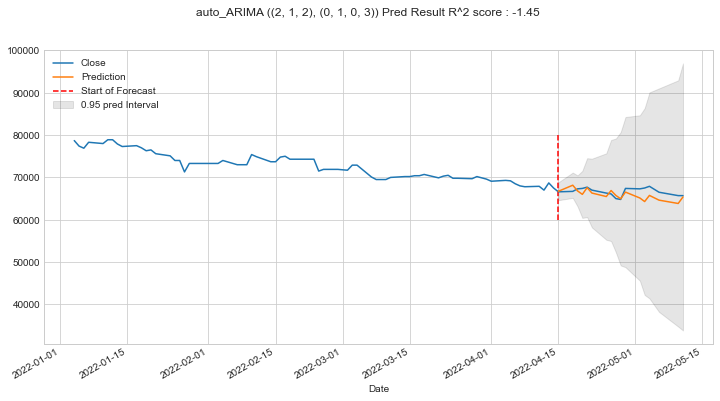

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.vlines('2022-04-15', 60000, 80000, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')

ax.legend(loc='upper left')
plt.suptitle(f'auto_ARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()

In [31]:
auto_arima_model = auto_arima(train_data['Close'], start_p=1, start_q=1, 
                             max_p=3, max_1=3, m=3, seasonal=False, # sarima(seasonal=True)
                             d=1, D=1,
                             max_P=3, max_Q=3, 
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True, 
                             stepwise=False)

auto_arima_model.summary()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1107.097, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1106.945, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1110.043, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1109.455, Time=0.03 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1110.559, Time=0.03 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1111.589, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1106.670, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1108.466, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1109.373, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1110.826, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1112.245, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1108.461, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1109.238, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1107.871, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1108.320, Time=0.23 sec
 ARIMA(3,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   68
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -543.459
Date:                Fri, 13 May 2022   AIC                           1100.917
Time:                        10:45:36   BIC                           1116.350
Sample:                             0   HQIC                          1107.024
                                 - 68                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -318.4917    519.172     -0.613      0.540   -1336.050     699.067
ar.L1         -1.9693      0.069    -28.655      0.000      -2.104      -1.835
ar.L2         -1.0741      0.122     -8.823      0.000      -1.313      -0.836
ar.L3         -0.0817      0.060     -1.354      0.176      -0.200       0.037
ma.L1          1.9378      0.038     50.676      0.000       1.863       2.013
ma.L2          0.9635      0.040     24.056      0.000       0.885       1.042
sigma2      7.252e+05      0.258   2.81e+06      0.000    7.25e+05    7.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                10.50
Prob(Q):                              0.84   Prob(JB):                         0.01
Heteroskedasticity (H):               0.63   Skew:                            -0.46
Prob(H) (two-sided):                  0.28   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+23. Standard errors may be unstable.
"""

In [32]:
pred = auto_arima_model.predict(len(test_data), return_conf_int=True)
pred_val = pred[0]
pred_ub = pred[1][:,0]
pred_lb = pred[1][:,1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)

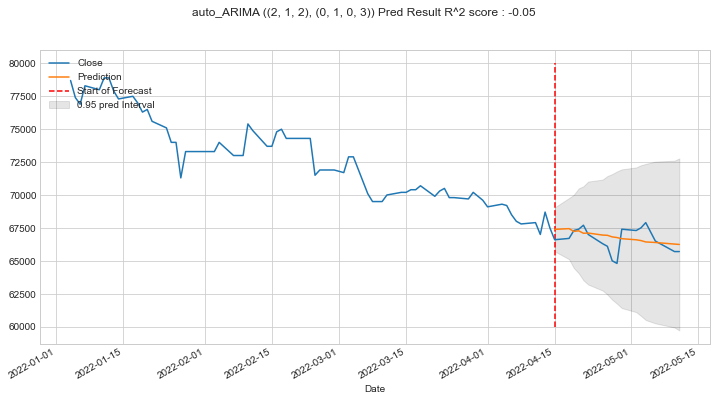

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.vlines('2022-04-15', 60000, 80000, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')

ax.legend(loc='upper left')
plt.suptitle(f'auto_ARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()